# Training script

### Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from transformers import AutoTokenizer, BertModel
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import string
import fasttext
from sklearn.svm import SVC
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from sklearn.metrics import accuracy_score, classification_report
import pickle

import os
os.makedirs('saved_models', exist_ok=True)

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight
transformer_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Models

In [2]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, num_cells, hidden_size, bi, out_features):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, num_layers = num_cells, hidden_size = hidden_size, bidirectional=bi, batch_first = True)
        self.batch_norm = nn.BatchNorm1d(num_features = hidden_size * 2 if bi else hidden_size)
        self.dropout = nn.Dropout(p = 0.2)
        self.relu1 = nn.ReLU()
        self.linear1 = nn.Linear(in_features = hidden_size * 2 if bi else hidden_size, out_features = out_features)
        #self.relu2 = nn.ReLU()
        #self.linear2 = nn.Linear(in_features = 100, out_features = out_features)
        
        # with torch.no_grad():
            # self.linear1.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
            # self.linear2.bias.fill_(-torch.log(torch.tensor(out_features - 1)))
    
    def forward(self, embedding_sequence):
        # Pad first sequence to max length
        # embedding_sequence[0] = torch.concat([embedding_sequence[0], torch.zeros((self.max_sequence_length - embedding_sequence[0].shape[0] ,self.input_size)).cuda()])
        # Get lenghts vector for every embeddings sequence to later use for packing
        lengths = torch.Tensor([embedding.shape[0] for embedding in embedding_sequence]).long()
        # Pad sequence
        padded_sequence = pad_sequence(embedding_sequence)
        # Pack sequence
        packed_sequence = pack_padded_sequence(padded_sequence, lengths = lengths, enforce_sorted = False)
        # print(padded_sequence.shape)
        
        packed_out, _ = self.lstm(packed_sequence)
        padded_out, _ = pad_packed_sequence(packed_out)
    
        # print(padded_out.shape)
    
        out_forward = padded_out[lengths - 1, range(padded_out.shape[1]), :self.hidden_size]
        out_reverse = padded_out[0, :, self.hidden_size:]
        
        # print(out_forward.shape)
        # print(out_reverse.shape)
        
        out = torch.cat([out_forward, out_reverse], dim = 1)
        
        # print(out.shape)
        
        x = self.batch_norm(out)
        x = self.dropout(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.linear1(x)
        #x = self.relu2(x)
        #x = self.linear2(x)
        return x

In [3]:
# model = MLP(37).cuda() # Replace model instantiation with another class here (SVC for example) if wishing to test other models
# model = XGBClassifier(n_estimators = 300, max_depth = 13, learning_rate = 0.01)
# model = XGBClassifier(n_estimators = 100, max_depth = 39 * 2, learning_rate = 0.01)
# model = SVC(C = 1, kernel = 'rbf', gamma = 'scale')
# TODO: somehting is wrong since the dict-based model achieves 0.30 accuracy
# and it only encounters 30/3000 not previously seen examples in the test set
# so it should have a 0.99 accuracy


nr_features = 768
batch_size = 32
learning_rate = 2e-5
epochs = 10
patience = 2
class_weight_beta = 1.0

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('Booking'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

### Loading the dataset

In [5]:

def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_to_be_retrieved_info(dataset, limit_nothing = False, limit_nothing_count = 200):
    user_act_types_list = []
    user_slots_per_act_type_list = []
    to_be_retrieved_list = []
    embeddings_list = []
    to_be_requested_list = []
    
    nothing_count = 0
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):
            # if speaker != 1:
                # continue
            # Skip using dialogue act intents
            # print(dialogue_act['dialog_act']['act_type'])
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                # continue
            # Skip using frame services
            # if 'other' in process_service_list(frames['service']):
                # continue
            services = frames['service']
            if speaker == 0:
                current_booking_service = [service for service in services if service in ["hotel", "restaurant"]]
                
            act_types = dialogue_act['dialog_act']['act_type']
            act_slots = dialogue_act['dialog_act']['act_slots']
            
            # if speaker == 1 and not any(act_type.startswith("Hotel") or act_type.startswith("Restaurant") or act_type.startswith("Booking") for act_type in act_types):
            #     user_act_types_list.pop()
            #     user_slots_per_act_type_list.pop()
            #     continue
            
            # print(act_types)
            if speaker == 0:
                if len([1 for act_type in dialogue_act['dialog_act']['act_type'] if act_type.startswith('general')]) == len(dialogue_act['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                    
                if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                if 'other' in process_intent_list(turns['dialogue_acts'][j + 1]['dialog_act']['act_type']):
                    skip_bot = True
                    continue
                skip_bot = False
            else:
                if skip_bot:
                    continue
            
            # print(act_slots)
            # print(act_types)
            slots_per_act_type = []
            to_be_retrieved = set()
            to_be_requested = set()
            for act_type, slots in zip(act_types, act_slots):
                slot_names = slots['slot_name']
                slot_values = slots['slot_value']
                
                domain = act_type.split('-')[0].lower()
                if domain == 'booking' and len(current_booking_service)==1:
                    domain = current_booking_service[0]
                
                # to_be_retrieved.add(domain + '-availability')
                
                # if 'hotel' in domain or 'restaurant' in domain:
                if speaker == 0: # When it's the user's turn
                    for slot_name, slot_value in zip(slot_names, slot_values):
                        if slot_name != 'none':
                            slots_per_act_type.append(act_type.lower() + '-' + slot_name + ':' + slot_value)
                else: # When it's the bot's turn
                    act_type_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value != '?' and slot_name != 'none']
                    to_be_retrieved.update(set([domain + '-' + slot_name + ':' + slot_value for slot_name, slot_value in act_type_relevant_slots]))
                    
                    if len(to_be_retrieved) != 0 and any((slot_name_value.split(":")[0]!=domain+"-none" for slot_name_value in to_be_retrieved)) and not "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability-yes')
                    elif "-No" in act_types:
                        to_be_retrieved.add(domain + '-availability-no')
                    
                    to_be_requested_relevant_slots = [(slot_name, slot_value) for slot_name, slot_value in zip(slot_names, slot_values) if slot_value == '?']
                    to_be_requested.update(set([domain + '-' + slot_name for slot_name, _ in to_be_requested_relevant_slots]))
                
            if speaker == 0: # When it's the user's turn
                user_act_types_list.append(act_types)
                user_slots_per_act_type_list.append(slots_per_act_type)
                
                # nr += 1
                # print(nr)
                # print("Input:", slots_per_act_type)
            else: # When it's the bot's turn
                if limit_nothing and len(to_be_requested) == 0:
                    if nothing_count == limit_nothing_count:
                        continue
                    nothing_count += 1
                
                if len(to_be_requested) == 0:
                    to_be_requested.add('NOTHING')
                
                to_be_retrieved_list.append(list(to_be_retrieved))
                to_be_requested_list.append(list(to_be_requested))
                
                # print(act_types)
                
                user_slots_per_act_type = user_slots_per_act_type_list[-1]
                to_be_retrieved = to_be_retrieved_list[-1]
                
                input_text = ', '.join(user_slots_per_act_type) + ' | ' + ', '.join(to_be_retrieved)
                print("INPUT TEXT:", input_text)
                
                print("TO BE REQ:", to_be_requested)
                
                tokenized_seen_slots = transformer_tokenizer(input_text)
                with torch.no_grad():
                    embedding = embedding_matrix[tokenized_seen_slots.input_ids].detach().numpy()
                embeddings_list.append(embedding)
            
    return embeddings_list, to_be_requested_list

In [6]:
dataset = load_dataset('multi_woz_v22')

try:
    train
    print("Dataset already loaded, moving on")
except:
    train = preprocess_split(dataset, 'train')
    test = preprocess_split(dataset, 'test')
    val = preprocess_split(dataset, 'validation')
    train_embeddings_list, train_to_be_requested_list = extract_to_be_retrieved_info(train)
    test_embeddings_list, test_to_be_requested_list = extract_to_be_retrieved_info(test)
    val_embeddings_list, val_to_be_requested_list = extract_to_be_retrieved_info(val)

No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/adrian/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

  2%|▏         | 133/6321 [00:00<00:09, 674.92it/s]

INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-food:African, restaurant-food:Asian, restaurant-food:British, restaurant-choice:several
TO BE REQ: set()
INPUT TEXT: restaurant-request-food:? | restaurant-name:Bedouin, restaurant-availability-yes, restaurant-area:centre, restaurant-food:Afrian
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:expensive, hotel-inform-type:hotel, restaurant-request-phone:? | restaurant-name:Bedouin, restaurant-availability-yes, hotel-area:center of town, hotel-availability-yes, restaurant-phone:01223367660, hotel-name:the University Arms Hotel
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: hotel-inform-bookday:saturday, hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref:FRGZWQL2, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-type:guesthouses, hotel-

  3%|▎         | 201/6321 [00:00<00:09, 656.01it/s]

INPUT TEXT: hotel-inform-area:south, hotel-inform-stars:3 | hotel-type:guesthouse, hotel-type:hotel, hotel-pricerange:moderately priced, hotel-availability-yes, hotel-pricerange:expensive
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes | hotel-parking:yes, hotel-availability-yes, hotel-internet:yes, hotel-choice:both
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookstay:4 | hotel-type:guesthouse, hotel-type:hotel, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT:  | hotel-ref:BS0ODSGJ, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:portuguese | restaurant-pricerange:cheap, restaurant-area:centre, restaurant-name:nandos city centre, restaurant-food:portuguese, restaurant-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:? | restaurant-availability-yes, restaurant-address:33-34 Saint Andrews Street, restaurant-name:nandos city centre
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:no, hotel-inform-type:h

  5%|▌         | 335/6321 [00:00<00:09, 661.93it/s]

INPUT TEXT: hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-availability-yes, hotel-choice:many
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: hotel-inform-area:north | hotel-choice:9, hotel-pricerange:cheap, hotel-pricerange:moderate, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-name:? | hotel-name:acorn guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookstay:3, hotel-request-ref:? | 
TO BE REQ: {'hotel-bookpeople', 'hotel-bookday'}
INPUT TEXT: hotel-inform-bookpeople:4 | 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: hotel-inform-bookday:wednesday | hotel-availability-yes, hotel-ref:6WKSPADC
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:no, hotel-inform-type:hotel | 
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-inform-area:dontcare, hotel-inform-pricerange:expensive, hotel-inform-stars:4 | hotel-choice:other, hotel-availability-yes, hotel-choice:first, hotel-name:the Huntingdo

  7%|▋         | 469/6321 [00:00<00:09, 642.65it/s]

INPUT TEXT: hotel-request-name:? | 
TO BE REQ: {'hotel-bookpeople', 'hotel-bookstay'}
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-food:british, restaurant-availability-yes, restaurant-area:centre, restaurant-name:Cambridge Chop House
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:16:45 | 
TO BE REQ: {'booking-booktime', 'booking-bookday'}
INPUT TEXT: restaurant-inform-booktime:15:45 | booking-ref:10P0LEVH, booking-availability-yes, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-parking:yes, hotel-internet:yes, hotel-availability-yes, hotel-stars:3, hotel-name:gonville hotel, hotel-area:town centre
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:friday, hotel-inform-bookpeople:1, hotel-inform-bookstay:4 | booking-ref:DRW9QM8S, general-a

  9%|▉         | 597/6321 [00:00<00:09, 626.74it/s]

 set()
INPUT TEXT: restaurant-request-area:? | restaurant-availability-yes, restaurant-area:south
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-stars:4 | hotel-choice:19, hotel-area:in town, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-name:acorn guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-address:? | hotel-address:154 chesterton road, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:7 | hotel-ref:5D2U451A, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | hotel-ref:DCLQRJ5I, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:asian oriental, restaurant-inform-pricerange:expensive | restaurant-area:center, res

 11%|█▏        | 723/6321 [00:01<00:09, 621.37it/s]

restaurant-inform-pricerange:moderate | restaurant-choice:31, restaurant-availability-yes
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-area:centre | restaurant-food:Asian Oriental, restaurant-availability-yes, restaurant-area:center, restaurant-choice:21, restaurant-food:Gastropub, restaurant-pricerange:moderately priced
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:11:45, restaurant-inform-food:asian oriental | restaurant-availability-yes, general-availability-yes, restaurant-ref:HQGN4WTQ
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:north, hotel-inform-internet:yes | 
TO BE REQ: {'hotel-type'}
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-choice:8, hotel-type:guesthouses, hotel-choice:two, hotel-type:hotels, hotel-availability-yes
TO BE REQ: {'hotel-type'}
INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:5 | hotel-phone:01223353071, hotel-nam

 13%|█▎        | 847/6321 [00:01<00:09, 595.34it/s]


TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-type:guesthouse | 
TO BE REQ: set()
INPUT TEXT: hotel-request-address:?, hotel-request-pricerange:? | hotel-pricerange:cheap, hotel-pricerange:moderate, hotel-availability-yes, hotel-pricerange:expensive, hotel-choice:three
TO BE REQ: set()
INPUT TEXT: hotel-request-address:?, hotel-request-pricerange:? | 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: hotel-request-address:?, hotel-request-pricerange:? | hotel-availability-yes, hotel-pricerange:cheap, hotel-phone:122 351 2596, hotel-name:rosa's bed and breakfast
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookpeople:4, hotel-inform-bookstay:7 | hotel-bookday:Monday, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-food:italian | restaurant-availability-yes, restaurant-name:Pizza Hut Cherry Hinton, restaurant-choice:2, restaurant-name:Frankie and Benny's
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:monday, restauran

 15%|█▌        | 976/6321 [00:01<00:08, 609.22it/s]

INPUT TEXT: restaurant-inform-bookday:monday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:30 | general-availability-yes, booking-booktime:15:30, booking-availability-yes, booking-bookpeople:7, booking-ref:C1555WJL, booking-bookday:Monday
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-pricerange:expensive | hotel-choice:5, hotel-type:hotel, hotel-internet:yes, hotel-availability-yes, hotel-pricerange:expensive
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:dontcare, hotel-inform-stars:4 | hotel-name:the huntingdon marriott hotel, hotel-address:kingfisher way, hinchinbrook business park, huntingdon, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | hotel-availability-yes, general-availability-yes, hotel-ref:VJ7YQQS7
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:a and b | hotel-pricerange:moderate, general-availability-yes, hotel-name:a and b guesthouse, ho

 18%|█▊        | 1107/6321 [00:01<00:08, 631.69it/s]

 {'restaurant-name', 'restaurant-food'}
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-pricerange:cheap | 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-food:Chinese, restaurant-pricerange:cheap, restaurant-name:Lucky Star
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-availability-yes, restaurant-postcode:cb17dy, restaurant-phone:01223244277, restaurant-address:Cambridge Leisure Park Clifton Way Cherry Hinton
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:4 | hotel-stars:4, hotel-choice:21, hotel-availability-yes
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-inform-area:south, hotel-inform-pricerange:cheap | hotel-stars:4, hotel-pricerange:cheap, hotel-name:Rosa's Bed and Breakfast, hotel-type:guesthouse, hotel-type:hotels, hotel-availability-yes, hotel-area:south
TO 

 20%|█▉        | 1235/6321 [00:01<00:08, 626.20it/s]

 set()
INPUT TEXT: hotel-request-postcode:? | hotel-postcode:cb58rs, hotel-availability-yes
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: hotel-inform-name:rosa's b&b | hotel-name:Rosa's, hotel-stars:4, hotel-pricerange:cheap, hotel-area:south side of town, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | hotel-name:Rosa's, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-pricerange:cheap, hotel-request-ref:? | hotel-availability-yes, hotel-name:Alexander bed and breakfast, hotel-ref:A36615HD
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:lovell lodge | hotel-type:hotel, hotel-availability-yes, hotel-pricerange:moderately priced, hotel-stars:2
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:lovell lodge, hotel-request-postcode:? | hotel-postcode:cb41sr, general-availability-yes, hotel-availability-yes
TO B

 22%|██▏       | 1374/6321 [00:02<00:07, 660.85it/s]

restaurant-inform-food:mexican | restaurant-food:Mexican, restaurant-name:The Chiquito Restaurant Bar, restaurant-availability-yes, restaurant-choice:one, restaurant-area:south
TO BE REQ: set()
INPUT TEXT: hotel-request-pricerange:?, restaurant-inform-area:south | restaurant-availability-yes, restaurant-postcode:cb17dy, restaurant-pricerange:expensive, restaurant-address:2G Cambridge Leisure Park Cherry Hinton Road Cherry Hinton
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:17:30 | 
TO BE REQ: {'restaurant-booktime', 'restaurant-bookday'}
INPUT TEXT: restaurant-inform-booktime:4:30 | restaurant-availability-yes, restaurant-bookpeople:1, restaurant-ref:P62404I5, restaurant-booktime:16:30
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:express by holiday inn cambridge, hotel-request-address:?, hotel-request-pricerange:? | hotel-address:coldhams business park, hotel-address:15-17 norman way, hotel-pricerange:expen

 24%|██▍       | 1507/6321 [00:02<00:07, 641.99it/s]

 set()
INPUT TEXT: restaurant-inform-bookpeople:2 | 
TO BE REQ: {'restaurant-booktime', 'restaurant-bookday'}
INPUT TEXT: restaurant-inform-pricerange:expensive, restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-availability-yes, restaurant-address:64 Cherry Hinton Road Cherry Hinton, restaurant-phone:01223412299, restaurant-postcode:cb17aa
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:british | restaurant-name:restaurant one seven, restaurant-availability-yes, restaurant-area:close to your location, restaurant-choice:several, restaurant-address:De Vere Univeristy Arms Regent Street City Centre
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre | restaurant-choice:4 other, restaurant-availability-yes, restaurant-food:British, restaurant-name:Restaurant One Seven, restaurant-area:centre of town
TO BE REQ: set()
INPUT TEXT: restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-pricerange:moderate


 26%|██▌       | 1638/6321 [00:02<00:07, 613.46it/s]

TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:cheap | hotel-pricerange:cheap, hotel-choice:10, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-type:guesthouse, restaurant-inform-area:centre | hotel-name:allenbell, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes | hotel-parking:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-address:?, hotel-request-postcode:? | hotel-postcode:cb13js, general-availability-yes, hotel-address:517a Coldham Lane, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:european | restaurant-availability-yes, restaurant-choice:lots of, restaurant-food:European
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name:the Galleria, restaurant-area:the town centre
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:sunday, restaurant-inform-booktime:18:15, restaurant-request-ref:? 

 27%|██▋       | 1700/6321 [00:02<00:07, 605.84it/s]

INPUT TEXT: restaurant-request-food:? | restaurant-availability-yes, restaurant-food:indian, restaurant-pricerange:moderate, restaurant-area:north, restaurant-name:the nirala, restaurant-food:fusion
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:16:00 | restaurant-bookpeople:two, restaurant-availability-yes, restaurant-bookday:Thursday, restaurant-ref:W7R9KEYJ, restaurant-booktime:16:00
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:mexican | restaurant-availability-yes, restaurant-name:chiquito restaurant bar, restaurant-area:south, restaurant-food:mexican
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-phone:01223400170, restaurant-availability-yes, restaurant-address:Cambridge Leisure Park Clifton Way Cherry Hinton, restaurant-postcode:CB17DY, restaurant-name:Chiquito Restaurant Bar
TO BE REQ: set()
INPUT TEXT: restaurant

 29%|██▉       | 1826/6321 [00:02<00:07, 602.30it/s]

{'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-request-internet:?, hotel-request-postcode:? | hotel-pricerange:moderate, hotel-internet:yes, hotel-availability-yes, hotel-type:guest house, hotel-area:west, general-availability-yes, hotel-name:Hobsons House
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:3 | general-availability-yes, hotel-phone:01223304906, hotel-availability-yes, hotel-address:96 barton road, hotel-stars:3, hotel-name:hobsons house
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-area:the south of town, restaurant-food:Italian, restaurant-food:modern european, restaurant-name:Restaurant Alimentum, restaurant-pricerange:moderately priced, restaurant-name:Pizza Hut Cherry Hinton
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:alimentum, restaurant-request-address:?, restaurant-request-phone:? | restaurant-phone:01223413000, restaurant-addr

 31%|███       | 1955/6321 [00:03<00:07, 618.89it/s]


TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:pizza express | restaurant-name:Pizza Express, restaurant-pricerange:moderately priced, general-availability-yes, restaurant-availability-yes, restaurant-area:center of town, restaurant-food:Italian
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-postcode:? | restaurant-availability-yes, restaurant-address:Regent Street City Centre, general-availability-yes, restaurant-postcode:cb21db
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:gonville | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:dontcare, restaurant-inform-food:scottish | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:modern european | restaurant-availability-yes, general-availability-yes, restaurant-food:European, restaurant-name:Eraina
TO BE REQ: set()
INPUT TEXT: restaurant-request-phone:? | restaurant-availability-yes, general-availability-yes, restaurant-phone:01223 368786
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:cent

 33%|███▎      | 2084/6321 [00:03<00:06, 624.78it/s]

 {'restaurant-booktime'}
INPUT TEXT: restaurant-inform-booktime:16:45 | restaurant-ref:80V5LKSU, restaurant-booktime:16:45, restaurant-availability-yes, restaurant-bookday:Thursday, restaurant-bookpeople:2
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-internet:no, hotel-inform-parking:no | hotel-area:north area, hotel-name:alpha-milton guest house, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-ref:? | 
TO BE REQ: {'hotel-bookpeople', 'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: restaurant-inform-food:spanish, restaurant-inform-pricerange:moderate | restaurant-name:La Tasca, restaurant-availability-yes, restaurant-food:Spanish, restaurant-area:town centre, restaurant-pricerange:moderate
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-area:?, restaurant-request-phone:? | restaurant-availability-yes, restaurant-area:Centre area, restaurant-address:14 -16 Bridge Street, resta

 35%|███▍      | 2209/6321 [00:03<00:06, 593.97it/s]

 | 
TO BE REQ: {'hotel-type'}
INPUT TEXT: hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | hotel-choice:so many, general-availability-yes, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-availability-yes, hotel-choice:11
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:centre, hotel-inform-bookstay:5 | hotel-area:Centre, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:north | hotel-type:guesthouses, hotel-name:Limehouse, hotel-name:Avalon, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5, hotel-inform-name:avalon | hotel-bookpeople:5, hotel-name:Avalon, hotel-ref:I3B3EKYI, general-availability-yes, hotel-availability-yes, hotel-bookstay:5
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:west, restaurant-inform-food:european | restaurant-area:west, restaurant-availability-yes, r

 37%|███▋      | 2329/6321 [00:03<00:06, 589.46it/s]

INPUT TEXT: hotel-inform-parking:yes | hotel-stars:4, hotel-pricerange:moderate, hotel-type:hotels, hotel-availability-yes
TO BE REQ: {'hotel-pricerange', 'hotel-stars'}
INPUT TEXT: hotel-inform-name:alexeander b&b | hotel-pricerange:cheap, hotel-type:guesthouse, hotel-name:Alexander bed and breakfast, hotel-area:centre of town, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:thursday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:friday | hotel-availability-yes, hotel-bookday:Friday
TO BE REQ: {'hotel-bookday'}
INPUT TEXT:  | hotel-ref:E79RSOWR, hotel-name:El Shaddai, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:italian, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-area:town centre, restaurant-choice:5, restaurant-food:italian, restaurant-pricerange:expensive, restaurant-area:south
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:dontc

 39%|███▉      | 2462/6321 [00:03<00:06, 627.34it/s]

INPUT TEXT: hotel-inform-bookpeople:2, hotel-inform-bookstay:2, hotel-inform-name:el shaddai | 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: hotel-inform-bookday:sunday, hotel-request-ref:? | 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: hotel-inform-bookstay:1, hotel-request-ref:? | hotel-ref:9H97D0MB, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:thai, restaurant-inform-pricerange:expensive | restaurant-food:Thai, restaurant-availability-yes, restaurant-area:west, restaurant-pricerange:expensive, restaurant-name:Sala Thong
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:45 | restaurant-ref:S2AY04JF, restaurant-availability-yes, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-name:aylesbray lodge guest house | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookpeople:2, hotel-inform-bookstay:2 | hot

 41%|████      | 2588/6321 [00:04<00:05, 622.45it/s]

restaurant-inform-area:centre, restaurant-inform-food:european | restaurant-availability-yes, restaurant-pricerange:expensive, restaurant-choice:several, restaurant-pricerange:moderate
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'hotel-name'}
INPUT TEXT: restaurant-inform-pricerange:expensive, restaurant-request-address:? | hotel-name:Eraina, hotel-availability-yes, hotel-address:Free School Lane City Centre, hotel-pricerange:expensive, hotel-phone:01223368786
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:moderate, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-name:acorn guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:sunday, hotel-inform-bookpeople:4, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref:7ZJ4CTTG, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:west, hotel-inform-parking:yes, hotel-inform-type:guesthouse | hotel-parking:yes, hotel-name:finches bed and breakfast, hotel-pricerange:c

 43%|████▎     | 2715/6321 [00:04<00:05, 620.18it/s]

TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:molecular gastronomy, restaurant-inform-pricerange:cheap | 
TO BE REQ: {'restaurant-pricerange', 'restaurant-food'}
INPUT TEXT: restaurant-inform-food:vietnamese, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-name:Thanh Binh, restaurant-address:17 Magdalene Street City Centre
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-phone:? | restaurant-availability-yes, restaurant-phone:01223362456, restaurant-address:17 Magdalene Street City Centre
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-type:guesthouse | hotel-choice:23, hotel-availability-yes
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-inform-type:guesthouse | hotel-choice:several, hotel-availability-yes, hotel-type:guesthouses
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes | 
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-request-name:? | hotel-stars:4, hote

 45%|████▍     | 2844/6321 [00:04<00:05, 624.34it/s]


TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-area:north | 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-name:loch fyne | restaurant-availability-yes, restaurant-name:The Loch Fyne, restaurant-postcode:cb21qy, restaurant-address:The Little Rose 37 Trumpington Street, restaurant-pricerange:expensive, restaurant-food:seafood, restaurant-area:centre, restaurant-phone:01223362433
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:8, restaurant-inform-booktime:15:00 | restaurant-availability-yes, restaurant-ref:6LB7GNEB
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-food:Modern european, restaurant-availability-yes, restaurant-food:Italian
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:dontcare | restaurant-name:Pizza Hut Cherry Hinton, restaurant-availability-yes, restaurant-pricerange:moderate, restaurant-food:Italian, restaurant-area:south
T

 47%|████▋     | 2974/6321 [00:04<00:05, 631.11it/s]

 set()
INPUT TEXT: hotel-inform-parking:yes | hotel-parking:yes, hotel-pricerange:cheap, hotel-pricerange:moderate, hotel-availability-yes, hotel-area:east, hotel-type:guesthouse, hotel-choice:5
TO BE REQ: set()
INPUT TEXT: hotel-request-internet:? | hotel-stars:4, hotel-parking:yes, hotel-internet:yes, hotel-availability-yes, hotel-name:The Allenbell
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:chinese | restaurant-availability-yes, restaurant-area:North
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:north, restaurant-inform-food:chinese | restaurant-availability-yes, restaurant-pricerange:moderate, restaurant-area:north, restaurant-food:chinese, restaurant-pricerange:expensive, restaurant-choice:3, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-choice:two, restaurant-name:hakka
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-

 49%|████▉     | 3101/6321 [00:04<00:05, 620.38it/s]

TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:chinese | 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:dontcare | restaurant-availability-yes, restaurant-name:the rice house, restaurant-address:88 Mill Road city centre, restaurant-pricerange:cheap
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:sunday | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:gonville hotel | hotel-pricerange:expensive, hotel-stars:3, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-area:? | hotel-availability-yes, hotel-area:town centre
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:indian | restaurant-pricerange:various, restaurant-availability-yes, restaurant-choice:several
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:30 | restaurant-availability-yes, restaurant-ref:PRYP175N, restaurant-name:saffron b

 51%|█████     | 3226/6321 [00:05<00:05, 599.16it/s]


TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:14:00, restaurant-inform-name:the gandhi | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-booktime:13:00 | restaurant-booktime:13:00, restaurant-availability-yes, general-availability-yes, restaurant-ref:C5ADLT6M
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:north, hotel-inform-type:hotel | hotel-area:north, hotel-availability-yes, hotel-choice:many
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-stars:2, hotel-inform-type:hotel | hotel-name:Ashley Hotel, hotel-name:Lovell lodge, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-type:hotel, hotel-request-postcode:? | hotel-availability-yes, hotel-postcode:cb41er
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-choice:21
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-in

 53%|█████▎    | 3364/6321 [00:05<00:04, 643.66it/s]


TO BE REQ: set()
INPUT TEXT: restaurant-request-address:? | restaurant-availability-yes, restaurant-address:only address, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-choice:several
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-area:dontcare, restaurant-inform-bookday:saturday | restaurant-availability-yes, restaurant-bookday:Saturday
TO BE REQ: set()
INPUT TEXT: restaurant-request-name:? | restaurant-availability-yes, general-availability-yes, restaurant-name:Curry Garden
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:italian, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-pricerange:expensive, restaurant-food:Italian, restaurant-choice:5
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-area:south | restaurant-address:Cambridge Leisure Park Clifton Way Cherry Hinton, restaurant-availability-yes, rest

 55%|█████▌    | 3493/6321 [00:05<00:04, 620.40it/s]

 set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-type:guesthouse, hotel-name:The Alexander Bed and Breakfast, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:6 | booking-bookstay:6 days 5 nights, booking-name:alexander bed and breakfast, booking-ref:2Z64N0C6, booking-bookpeople:3, booking-availability-yes, booking-bookday:wednesday
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:cotto | restaurant-area:center, restaurant-name:Cotto, restaurant-pricerange:moderately priced, restaurant-availability-yes, restaurant-food:British
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:13:30 | booking-ref:AS8Z2W5W, booking-availability-yes, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:north, restaurant-inform-food:northern european | 
TO BE REQ: {'restaurant-area', 'restaurant-fo

 56%|█████▋    | 3556/6321 [00:05<00:04, 576.61it/s]

restaurant-inform-food:indian | restaurant-availability-yes, restaurant-choice:a few
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-pricerange:dontcare | restaurant-availability-yes, restaurant-pricerange:expensive, restaurant-name:saffron brasserie
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-phone:? | restaurant-availability-yes, restaurant-phone:012233574679, restaurant-address:Hills Road City Centre
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:west, hotel-inform-type:hotel | hotel-pricerange:cheap, hotel-name:Cambridge Belfry, hotel-name:The Huntingdon Marriott, hotel-availability-yes, hotel-pricerange:expensive
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:1 | hotel-type:hotels, hotel-stars:1, hotel-area:that part of town, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:west, hotel-inform-stars:4, hotel-inform-type:hotel | general-availability-yes, hotel-type:hotels, hotel-availability-yes
TO BE REQ:

 58%|█████▊    | 3674/6321 [00:05<00:04, 573.98it/s]

INPUT TEXT: hotel-request-postcode:? | hotel-availability-yes, hotel-postcode:cb12de
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:spanish | restaurant-food:spanish, restaurant-availability-yes, restaurant-choice:two, restaurant-pricerange:cheap, restaurant-area:city centre, restaurant-name:La raza, restaurant-pricerange:moderately priced, restaurant-name:La tasca
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:moderate | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:19:30 | restaurant-availability-yes, restaurant-ref:U7OJBNT7, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:cheap, hotel-inform-type:guesthouse | hotel-choice:9, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-stars:4 | hotel-name:Allenbell, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:saturday, hotel-inform-bookpeople:7, hote

 60%|██████    | 3795/6321 [00:06<00:04, 567.77it/s]

INPUT TEXT: restaurant-inform-food:indian, restaurant-inform-pricerange:moderate | restaurant-food:Indian, restaurant-availability-yes, restaurant-pricerange:moderate, restaurant-choice:four
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-area:east | restaurant-availability-yes, restaurant-name:Curry Prince, restaurant-area:east
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:10:45 | restaurant-availability-yes, restaurant-ref:96K0BBZZ
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:chinese | 
TO BE REQ: {'restaurant-area', 'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-bookday:friday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:15:45, restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref:3BU5HSE9, general-availability-yes
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-food:indian | restaurant-availability-ye

 62%|██████▏   | 3918/6321 [00:06<00:04, 584.17it/s]


TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-bookday:tuesday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2, hotel-inform-stars:4 | hotel-bookday:tuesday, hotel-bookstay:3 days 2 nights, hotel-ref:OVCFXDNP, hotel-availability-yes, hotel-name:limehouse, hotel-bookpeople:3
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'restaurant-name'}
INPUT TEXT: restaurant-inform-name:city stop restaurant | 
TO BE REQ: {'restaurant-bookday'}
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:15 | restaurant-availability-yes, restaurant-ref:AWV50VGM
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-stars:5 | hotel-availability-yes, hotel-stars:no, hotel-stars:several
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-choice:17, hotel-stars:4, hotel-type:hotels, hotel-stars:5, hotel-availability-yes, hotel-area:the area
TO BE REQ: set()
INPUT TEXT: hotel-request-name:? | hotel-parking:yes, hotel-s

 64%|██████▍   | 4048/6321 [00:06<00:03, 611.46it/s]

set()
INPUT TEXT: hotel-inform-area:centre, hotel-inform-stars:4 | hotel-pricerange:cheap, hotel-pricerange:expensive, hotel-choice:two, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-availability-yes, general-availability-yes, hotel-name:alexander bed and breakfast, hotel-name:university arms hotel
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | hotel-availability-yes, hotel-internet:yes, hotel-choice:both
TO BE REQ: set()
INPUT TEXT: hotel-request-phone:? | hotel-phone:01223525725, hotel-name:Alexander bed and breakfast, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-name:? | hotel-phone:01223351241, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:european, restaurant-inform-pricerange:cheap | restaurant-address:Quayside Off Bridge Street, restaurant-name:The River Bar Steakhouse and Grill, restaurant-area:centre, restaurant-availability-ye

 66%|██████▌   | 4174/6321 [00:06<00:03, 570.96it/s]

 set()
INPUT TEXT: hotel-inform-bookday:saturday, hotel-inform-bookstay:4 | 
TO BE REQ: {'hotel-bookpeople'}
INPUT TEXT: hotel-inform-bookpeople:8 | 
TO BE REQ: {'hotel-name'}
INPUT TEXT: hotel-inform-name:leverton house, hotel-inform-pricerange:cheap | hotel-ref:KZBURD59, hotel-name:allenbell, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:north, hotel-inform-type:guesthouse | hotel-type:guesthouses, hotel-choice:five, hotel-availability-yes
TO BE REQ: {'hotel-parking', 'hotel-internet'}
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-type:guesthouses, hotel-choice:7, hotel-parking:yes, hotel-pricerange:moderately priced, hotel-availability-yes
TO BE REQ: {'hotel-stars'}
INPUT TEXT: hotel-inform-bookday:wednesday | hotel-name:the Archway House, hotel-availability-yes
TO BE REQ: {'hotel-bookpeople', 'hotel-bookstay'}
INPUT TEXT: hotel-inform-bookpeople:7, hotel-inform-bookstay:3, hotel-request-ref:? | 
TO BE REQ: {'hotel-bookday', '

 68%|██████▊   | 4295/6321 [00:07<00:03, 578.94it/s]


TO BE REQ: {'hotel-type'}
INPUT TEXT: hotel-inform-stars:4 | hotel-pricerange:cheap, hotel-type:guesthouse, hotel-area:east area of town, hotel-availability-yes, hotel-name:The Allenbell
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes | hotel-parking:yes, hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:tuesday, hotel-inform-bookpeople:7, hotel-inform-bookstay:4, hotel-inform-stars:4 | hotel-ref:8JGLKXB8, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:west, restaurant-inform-pricerange:moderate | restaurant-food:british, restaurant-availability-yes, restaurant-food:indian, restaurant-food:italian
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:dontcare | restaurant-name:Prezzo, restaurant-availability-yes, restaurant-food:italian
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:20:00 | restaurant-booktime:20:00, restaurant-availa

 70%|██████▉   | 4423/6321 [00:07<00:03, 598.53it/s]

INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-bookpeople:2 | 
TO BE REQ: {'booking-bookstay'}
INPUT TEXT: hotel-inform-bookstay:2 | hotel-ref:1H5BM0PN, hotel-bookstay:2, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:indian, restaurant-inform-pricerange:moderate | 
TO BE REQ: {'restaurant-booktime', 'restaurant-bookday'}
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:12:45 | restaurant-availability-yes, restaurant-ref:MDKCBM4S
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:african, restaurant-inform-pricerange:expensive | restaurant-name:bedouin at 100 Mill Road City Centre, restaurant-availability-yes, restaurant-area:Center, restaurant-choice:one
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:12:00 | 
TO BE REQ: set()
INPUT TEXT: restaurant-request-ref:? | restaurant-availab

 71%|███████   | 4488/6321 [00:07<00:02, 611.23it/s]


TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:royal spice | restaurant-availability-yes, restaurant-food:indian, restaurant-address:Victoria Avenue Chesterton, restaurant-area:north, restaurant-name:Royal Spice, restaurant-pricerange:pretty cheap
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:monday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:30 | restaurant-availability-yes, restaurant-ref:YFFSHC02, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:mexican | restaurant-food:Mexican, general-availability-yes, restaurant-availability-yes, restaurant-name:Chiquito Restaurant Bar, restaurant-choice:only
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:asian oriental, restaurant-request-phone:? | restaurant-availability-yes, restaurant-choice:four, restaurant-area:centre, restaurant-food:Asian oriental
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:dontcare | restau

 73%|███████▎  | 4615/6321 [00:07<00:02, 576.02it/s]

INPUT TEXT:  | 
TO BE REQ: {'hotel-area'}
INPUT TEXT: restaurant-inform-area:west, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-choice:9
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:british | restaurant-availability-yes, restaurant-choice:two, restaurant-name:Graffiti, restaurant-name:travellers rest
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:11:00, restaurant-inform-name:travellers rest | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-booktime:10:00 | restaurant-availability-yes, general-availability-yes, restaurant-booktime:10:00, restaurant-ref:TX8BTBJT
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:rosa's | 
TO BE REQ: {'hotel-bookpeople', 'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT:  | hotel-stars:4, hotel-type:guesthouse, general-availability-yes, hotel-name:Rosa's bed and breakfast, hotel-availability-yes, hotel-area:South
TO BE REQ: set()
INPUT TEXT: re

 75%|███████▍  | 4739/6321 [00:07<00:02, 580.40it/s]


TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-area:Centre, restaurant-choice:many, restaurant-pricerange:expensive, restaurant-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:european | restaurant-address:Free School Lane City Centre, restaurant-name:Eraina, general-availability-yes, restaurant-availability-yes, restaurant-food:European
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:11:30 | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:moroccan | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:cheap | restaurant-food:Mexican, restaurant-availability-yes, restaurant-name:La Raza, restaurant-pricerange:cheap, restaurant-area:centre
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:mediterranean | restaurant-food:Mediterranean, restaurant-pricerang

 77%|███████▋  | 4856/6321 [00:08<00:02, 542.97it/s]

INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:city centre north b and b | hotel-availability-yes, hotel-ref:II677Z30, hotel-name:The A and B
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-food:Indian, restaurant-choice:14, restaurant-pricerange:expensive, restaurant-availability-yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-area:centre | restaurant-availability-yes, restaurant-address:106 Regent Street City Centre, restaurant-name:Curry Garden
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:curry garden, restaurant-request-address:?, restaurant-request-postcode:? | restaurant-availability-yes, restaurant-postcode:cb21dp, restaurant-name:Curry Garden
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:west, restaurant-inform-pricerange:cheap | restaurant-availability-yes, restaurant-food:vietnamese, restau

 79%|███████▉  | 4978/6321 [00:08<00:02, 574.00it/s]

INPUT TEXT: restaurant-inform-food:indian | restaurant-area:south part of town, general-availability-yes, restaurant-name:Taj Tandoori, restaurant-availability-yes, restaurant-pricerange:expensive
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:tuesday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:19:30 | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:indian | restaurant-availability-yes, restaurant-booktime:19:30, restaurant-bookpeople:3, restaurant-bookday:Tuesday
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: restaurant-inform-booktime:18:30 | restaurant-ref:8L32ED7Q, restaurant-booktime:18:30, restaurant-name:Taj Tandoori, restaurant-availability-yes, restaurant-bookday:Tuesday
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:south, hotel-inform-stars:4 | hotel-name:Rosa's bed and breakfast, hotel-name:Aylesbray lodge guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | general-availability-yes, hotel-internet:yes, ho

 80%|███████▉  | 5036/6321 [00:08<00:02, 557.35it/s]

INPUT TEXT: hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4, hotel-inform-stars:4 | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-stars:4 | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookstay:4, hotel-inform-stars:3 | hotel-area:east, hotel-type:any kind, hotel-area:centre, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:centre, hotel-inform-stars:4 | hotel-choice:lots, hotel-stars:4, hotel-type:hotels, hotel-availability-yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: hotel-inform-bookday:thursday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4, hotel-inform-pricerange:expensive | hotel-stars:4, hotel-type:hotels, hotel-availability-yes, hotel-area:east, hotel-pricerange:expensive
TO BE REQ: {'hotel-pricerange', 'hotel-stars', 'hotel-area'}
INPUT TEXT: hotel-inform-area:dontcare, hotel-inform-stars:4 | hotel-type:hotel, hotel-availability-yes, hotel-name:Gonville Hotel, hotel-area:centre, hotel

 82%|████████▏ | 5156/6321 [00:08<00:02, 451.92it/s]

INPUT TEXT: hotel-inform-bookpeople:5 | hotel-ref:UPYAJTEP, hotel-availability-yes, hotel-name:the Lovell Lodge, hotel-bookstay:4, hotel-bookpeople:5, hotel-bookday:Saturday
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:4 | hotel-name:acorn guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-name:acorn guest house, hotel-inform-parking:yes | hotel-parking:yes, hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-stars:4, hotel-parking:yes, hotel-type:hotel, hotel-availability-yes, hotel-choice:three
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | hotel-stars:four, hotel-name:the cambridge belfry, hotel-parking:yes, hotel-pricerange:cheap, hotel-internet:yes, hotel-availability-yes, hotel-area:west
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:thursday, hotel-inform-bookpeople:2, hotel-inform-bookstay:3 | 
TO BE REQ: set()

 83%|████████▎ | 5261/6321 [00:08<00:02, 480.18it/s]

restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-choice:several
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-food:italian | restaurant-availability-yes, restaurant-name:Caffe Uno, restaurant-address:32 Bridge Street
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:monday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:18:15 | restaurant-ref:E3CNAP2, restaurant-availability-yes, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-parking:yes, hotel-availability-yes, hotel-pricerange:cheap, hotel-stars:4, hotel-name:acorn guest house, hotel-internet:yes, hotel-address:56 saint barnabas road
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:3 | hotel-stars:3, hotel-name:Bridge Guest House, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:6, hotel-inform-bookstay:4 | hotel-ref:2I3

 85%|████████▌ | 5381/6321 [00:09<00:01, 534.80it/s]

 set()
INPUT TEXT: hotel-inform-area:north | 
TO BE REQ: {'hotel-pricerange', 'hotel-parking', 'hotel-internet'}
INPUT TEXT: hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5, hotel-request-ref:? | hotel-ref:EOPOKFF6, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:west, hotel-inform-type:hotel | hotel-pricerange:cheap, hotel-type:guesthouse, hotel-choice:1, hotel-type:hotel, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes | hotel-name:The Cambridge Belfry, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:friday, hotel-inform-bookpeople:6, hotel-inform-bookstay:3 | hotel-bookstay:three, hotel-bookpeople:6, hotel-availability-yes, hotel-bookday:Friday
TO BE REQ: set()
INPUT TEXT: hotel-request-ref:? | 
TO BE REQ: set()
INPUT TEXT:  | hotel-ref:C12WFP62, hotel-name:Finches Bed and Breakfast, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
IN

 87%|████████▋ | 5503/6321 [00:09<00:01, 558.85it/s]

 set()
INPUT TEXT: hotel-inform-parking:dontcare, hotel-inform-pricerange:moderate | hotel-area:south side of town, hotel-name:Bridge Guest House, hotel-name:Aylesbray Lodge Guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:centre | hotel-name:Cityroomz, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:6, hotel-inform-bookstay:5 | hotel-availability-yes, general-availability-yes, hotel-ref:KJWXHZQV
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:lebanese, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name:ali baba, restaurant-choice:one
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-postcode:? | restaurant-postcode:cb21nt, restaurant-availability-yes, restaurant-address:59 Hills Road City Centre
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:b guesthouse | hotel-stars:4, hotel-type:guesthouse, hotel-pricerange:moderately priced, h

 88%|████████▊ | 5561/6321 [00:09<00:01, 560.03it/s]

 {'hotel-pricerange'}
INPUT TEXT: hotel-request-name:? | hotel-pricerange:cheap, hotel-type:guesthouse, hotel-name:Allenbell, hotel-area:East, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:5, hotel-inform-bookstay:2 | hotel-ref:BD7V5LON, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:portuguese, restaurant-inform-pricerange:cheap, restaurant-request-address:?, restaurant-request-area:?, restaurant-request-phone:? | restaurant-availability-yes, restaurant-food:Portuguese, restaurant-pricerange:cheap, restaurant-name:Nandos, restaurant-address:Cambridge Leisure Park Clifton Way, restaurant-area:south, restaurant-phone:01223 327908
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-food:indian, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-name:The Taj Tandoori
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:? | restaurant-availability

 90%|████████▉ | 5680/6321 [00:09<00:01, 573.67it/s]

INPUT TEXT: restaurant-inform-food:modern european, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-choice:at least three
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south | restaurant-availability-yes, restaurant-name:restaurant alimentum, restaurant-area:south side of town
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:30 | restaurant-booktime:12:30, general-availability-yes, restaurant-ref:X08RCBWH, restaurant-availability-yes, restaurant-bookday:Wednesday
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:modern european, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-pricerange:moderate, general-availability-yes, restaurant-choice:Two, restaurant-choice:one, restaurant-area:centre, restaurant-area:south, restaurant-choice:three
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:5, rest

 92%|█████████▏| 5808/6321 [00:09<00:00, 600.87it/s]

TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-food:kosher, restaurant-inform-pricerange:dontcare | restaurant-food:Kosher, restaurant-availability-yes
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-food:asian oriental | restaurant-pricerange:inexpensive, restaurant-name:J Restaurant, restaurant-availability-yes, restaurant-name:Dojo noodle bar, restaurant-choice:2
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:noodle bar | 
TO BE REQ: {'restaurant-bookpeople', 'restaurant-booktime', 'restaurant-bookday'}
INPUT TEXT: restaurant-inform-booktime:16:00 | restaurant-availability-yes, restaurant-ref:0EGLWEQK, general-availability-yes, restaurant-name:the Dojo Noodle Bar
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:east, restaurant-inform-pricerange:expensive | restaurant-food:british, restaurant-area:east part of town, restaurant-name:Grafton hotel restaurant, general-availability-yes, restaurant-availability-yes, restaurant-pricerange:expensive

 94%|█████████▍| 5943/6321 [00:10<00:00, 614.46it/s]

INPUT TEXT: restaurant-inform-bookday:sunday, restaurant-inform-booktime:12 | restaurant-availability-yes, restaurant-ref:EZ8L6J51, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:east | 
TO BE REQ: {'restaurant-pricerange', 'restaurant-food'}
INPUT TEXT: restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:15:45, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-address:451 Newmarket Road Fen Ditton, restaurant-name:Curry Prince
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookpeople:3 | restaurant-availability-yes, restaurant-ref:4269Q40G
TO BE REQ: set()
INPUT TEXT: hotel-inform-type:hotel | hotel-type:hotel, hotel-availability-yes, hotel-choice:33
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-area:east, hotel-name:the Autumn House, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:saturday, 

 96%|█████████▌| 6067/6321 [00:10<00:00, 599.68it/s]

INPUT TEXT: restaurant-inform-food:italian | restaurant-availability-yes, restaurant-name:Ask, restaurant-choice:3
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:moroccan | restaurant-availability-yes, restaurant-area:in the city, restaurant-food:Moroccan
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-food:portuguese | restaurant-availability-yes, restaurant-food:Portuguese, restaurant-name:nandos city centre
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookpeople:4, restaurant-inform-booktime:17:00 | restaurant-bookpeople:4, general-availability-yes, restaurant-availability-yes, restaurant-name:the nandos city centre, restaurant-booktime:17:00
TO BE REQ: set()
INPUT TEXT: restaurant-request-ref:? | restaurant-availability-yes, restaurant-ref:WS5P73O7
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:45 | restaurant-ref:69XP42LR, restaurant-availability-yes, general-availability-yes
TO BE RE

 98%|█████████▊| 6195/6321 [00:10<00:00, 557.94it/s]

INPUT TEXT: hotel-inform-bookpeople:4, hotel-inform-pricerange:expensive, hotel-inform-stars:2, restaurant-inform-bookpeople:4, restaurant-inform-booktime:16:15 | hotel-name:Express by Holiday Inn Cambridge, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:yes | hotel-parking:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:5 | hotel-ref:9WCO5NO5, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-name:acorn guest house, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-address:? | hotel-address:154 chesterton road, hotel-availability-yes, hotel-postcode:cb41da
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:ex

100%|█████████▉| 6307/6321 [00:10<00:00, 529.23it/s]

{'hotel-area'}
INPUT TEXT: hotel-inform-type:guesthouse | hotel-name:Rosa's bed and breakfast, hotel-type:guesthouse, hotel-availability-yes, hotel-area:south
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:rosa's | 
TO BE REQ: {'hotel-bookday'}
INPUT TEXT: hotel-request-internet:? | general-availability-yes, hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-request-internet:? | hotel-name:Rosa's, hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:west | hotel-area:west, hotel-availability-yes, hotel-choice:four
TO BE REQ: {'hotel-type'}
INPUT TEXT: hotel-inform-type:guesthouse | hotel-pricerange:cheap, hotel-name:Finches Bed and Breakfast, hotel-pricerange:moderately priced, hotel-availability-yes, hotel-stars:3, hotel-name:Hobson's House
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:finches, hotel-request-postcode:? | hotel-availabili

100%|██████████| 6321/6321 [00:10<00:00, 590.63it/s]


INPUT TEXT: restaurant-inform-bookday:friday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:30 | restaurant-booktime:that time slot, restaurant-availability-yes
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: restaurant-inform-booktime:14:30 | restaurant-availability-yes, restaurant-booktime:14:30, general-availability-yes, restaurant-ref:7H21OO6L
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:cheap, hotel-inform-stars:4, hotel-inform-type:hotel | hotel-name:The Cambridge Belfry, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:friday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | hotel-ref:I5ZE4AQV, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:centre, hotel-inform-type:hotel | hotel-area:center of town, hotel-pricerange:moderate, hotel-availability-yes, hotel-pricerange:expensive, hotel-choice:three
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-stars:3 | hotel-parking:yes, hotel-name:the

  7%|▋         | 52/745 [00:00<00:01, 511.63it/s]

INPUT TEXT: restaurant-inform-name:golden wok | restaurant-availability-yes, restaurant-address:191 Histon Road Chesterton
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:friday, restaurant-inform-booktime:11:00 | restaurant-availability-yes, restaurant-bookpeople:1
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookpeople:4 | restaurant-ref:MUFCMYFF, restaurant-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-type:hotel | hotel-availability-yes, hotel-choice:many
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-name:the Lovell Lodge, hotel-type:hotel, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:friday, hotel-inform-bookpeople:3, hotel-inform-bookstay:2 | general-availability-yes, hotel-ref:9HMD04UW, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-pricerange:moderate | 
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-a

 23%|██▎       | 168/745 [00:00<00:01, 564.53it/s]


TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookpeople:2 | restaurant-availability-yes, restaurant-ref:ADPJRX82, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:panasian, restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-pricerange:expensive, restaurant-food:panasain
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-food:mediterranean | restaurant-name:la mimosa, restaurant-area:centre, restaurant-choice:a couple, restaurant-availability-yes, restaurant-name:shiraz restaurant
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:wednesday, restaurant-inform-bookpeople:7, restaurant-inform-booktime:15:15, restaurant-inform-name:la mimosa | restaurant-ref:ER5DFE50, restaurant-availability-yes, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:4 | hotel-stars:4, hotel-choice:21, hotel-availability-yes
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-

 38%|███▊      | 285/745 [00:00<00:00, 536.69it/s]

restaurant-inform-area:centre, restaurant-inform-food:brazliian | 
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-food:british | 
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:moderate | 
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-bookday:monday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:13:00 | restaurant-availability-yes, restaurant-ref:S59IHPUI, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-pricerange:cheap | hotel-pricerange:cheap, hotel-choice:multiple, hotel-parking:yes, hotel-type:hotels, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-stars:3 | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-pricerange:moderate, hotel-inform-stars:3 | 
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-availability-yes, hotel-area:north, hotel-area:west, hotel-choice:3, h

 54%|█████▍    | 404/745 [00:00<00:00, 563.94it/s]

INPUT TEXT: restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:2, restaurant-inform-booktime:20:00 | 
TO BE REQ: {'restaurant-booktime'}
INPUT TEXT: restaurant-inform-booktime:19:00 | restaurant-availability-yes, restaurant-ref:ZN0CVH11, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:jamaican | restaurant-availability-yes, restaurant-area:centre of town, restaurant-food:Jamaican
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-food:indian | restaurant-availability-yes, restaurant-choice:several
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:dontcare | restaurant-choice:9, restaurant-name:The Golden Curry, restaurant-availability-yes, restaurant-food:Indian, restaurant-pricerange:expensive, restaurant-area:centre of town
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:tuesday | 
TO BE REQ: {'booking-bookpeople'}
INPUT TEXT: restaurant-inform-bookpeople:2, restaurant

 70%|███████   | 522/745 [00:00<00:00, 551.62it/s]

hotel-request-pricerange:? | hotel-name:Allenbell, hotel-pricerange:cheap, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:north, hotel-inform-parking:yes | hotel-availability-yes, hotel-choice:11
TO BE REQ: {'hotel-internet'}
INPUT TEXT: hotel-inform-internet:dontcare | hotel-choice:9, hotel-availability-yes, hotel-type:guesthouses
TO BE REQ: {'hotel-stars'}
INPUT TEXT: hotel-inform-stars:3 | hotel-parking:yes, hotel-name:Acorn Guest House, hotel-stars:4, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:thursday, hotel-inform-bookpeople:7, hotel-inform-bookstay:2 | hotel-availability-yes, hotel-ref:Y41W8UWB
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:ashley hotel | hotel-availability-yes, hotel-postcode:cb41er, hotel-address:74 Chesterton Road, hotel-name:The Ashley Hotel
TO BE REQ: set()
INPUT TEXT:  | hotel-type:hotel, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:expen

 86%|████████▌ | 639/745 [00:01<00:00, 547.74it/s]

{'restaurant-food'}
INPUT TEXT: restaurant-inform-food:chinese | restaurant-food:chinese, restaurant-availability-yes, restaurant-choice:ten
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-inform-pricerange:expensive | restaurant-choice:4, restaurant-availability-yes, restaurant-name:Tang Chinese
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:monday, restaurant-inform-bookpeople:4, restaurant-inform-booktime:17:30 | restaurant-bookpeople:4, restaurant-ref:1KLUAE2J, restaurant-availability-yes, restaurant-bookday:Monday, restaurant-booktime:17:30
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-area:west | restaurant-food:british, restaurant-availability-yes, restaurant-name:graffiti
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:sunday, restaurant-inform-bookpeople:5, restaurant-inform-booktime:18:00 | restaurant-availability-yes, restaurant-ref:SATXTMCN, general-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel

100%|██████████| 745/745 [00:01<00:00, 562.52it/s]


TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-stars:3, hotel-inform-type:hotel | hotel-choice:5, hotel-availability-yes
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-inform-pricerange:expensive, hotel-inform-stars:3, hotel-inform-type:hotel, hotel-request-address:?, hotel-request-area:?, restaurant-inform-area:west, restaurant-inform-food:chinese, restaurant-inform-pricerange:cheap | restaurant-availability-yes, hotel-address:53-57 Lensfield Road cb21en, restaurant-area:the west side, restaurant-pricerange:cheap, hotel-availability-yes, restaurant-food:chinese, hotel-name:The Lensfield Hotel, hotel-area:South
TO BE REQ: set()
INPUT TEXT: hotel-inform-type:hotel, restaurant-inform-area:centre, restaurant-inform-food:indian | restaurant-address:74 mill road city centre, restaurant-availability-yes, restaurant-pricerange:cheap, restaurant-name:kohinoor
TO BE REQ: set()
INPUT TEXT: hotel-request-address:?, restaurant-request-phone:?, restaurant-requ

  0%|          | 0/762 [00:00<?, ?it/s]

INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:chinese | restaurant-availability-yes, restaurant-pricerange:all price ranges
TO BE REQ: {'restaurant-pricerange'}
INPUT TEXT: restaurant-request-address:?, restaurant-request-postcode:?, restaurant-request-pricerange:? | restaurant-address:Regent Street City Centre, restaurant-pricerange:cheap, restaurant-name:Charlie Chan, restaurant-postcode:cb21db, general-availability-yes, restaurant-availability-yes
TO BE REQ: set()
INPUT TEXT:  | general-availability-yes, hotel-availability-yes, hotel-area:Cambridge, hotel-choice:a variety
TO BE REQ: {'hotel-pricerange'}
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-stars:4, hotel-inform-type:guesthouse | hotel-choice:several, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:west | hotel-type:guesthouse, hotel-name:Finches Bed and Breakfast, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:monday, hotel-inform-bookpeople:2

 15%|█▍        | 114/762 [00:00<00:01, 576.35it/s]

INPUT TEXT: hotel-inform-name:a and b guest house | hotel-type:hotel, hotel-stars:4, hotel-internet:yes, hotel-name:the a and b guest house, hotel-availability-yes, hotel-area:east
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:thursday, hotel-inform-bookpeople:7, hotel-inform-bookstay:3 | hotel-ref:FBDR5BNR, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre | restaurant-availability-yes, restaurant-food:Afghan, restaurant-area:Cambridge, restaurant-pricerange:expensive, restaurant-choice:several, restaurant-area:centre
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:indian | restaurant-name:and Curry Queen, restaurant-choice:6, restaurant-name:The Golden Curry, restaurant-name:Curry Garden, restaurant-name:Saffron Brasserie, restaurant-name:Curry King, restaurant-availability-yes, restaurant-food:indian, restaurant-name:Panahar, restaurant-pricerange:expensive
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:curry queen, restaurant-request-pos

 23%|██▎       | 172/762 [00:00<00:01, 526.13it/s]

INPUT TEXT: restaurant-inform-bookday:friday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:14:30 | restaurant-name:la raza, restaurant-availability-yes, general-availability-yes, restaurant-ref:D0K5VZN7
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'hotel-pricerange', 'hotel-type'}
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-pricerange:moderate, hotel-inform-type:guesthouse | hotel-type:guesthouses, hotel-choice:14, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:dontcare | hotel-name:Avalon, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:saturday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | hotel-ref:KPBDLEXW, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:rice boat | restaurant-food:upscale Indian, restaurant-name:Rice Boat, restaurant-phone:01223302800, restaurant-address:37 Newnham Road, restaurant-availability-yes
TO BE REQ: set()
INPUT TEXT:

 31%|███       | 235/762 [00:00<00:00, 564.02it/s]

INPUT TEXT:  | restaurant-food:african, restaurant-availability-yes, restaurant-food:asian
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:modern european | restaurant-choice:4, restaurant-availability-yes
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name:riverside brasserie, restaurant-name:de luca cucina and bar
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:saturday, restaurant-inform-bookpeople:3, restaurant-inform-booktime:19:00 | 
TO BE REQ: {'restaurant-booktime', 'restaurant-bookday'}
INPUT TEXT: restaurant-inform-booktime:18:00 | restaurant-availability-yes, restaurant-ref:CAOHGDS4, restaurant-booktime:18:00
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-pricerange:moderate | restaurant-availability-yes, restaurant-name:Restaurant Alimentum, restaurant-choice:one of these, restaurant-name:Pizza Hut Cherry Hinton
TO

 38%|███▊      | 292/762 [00:00<00:00, 532.29it/s]

INPUT TEXT: restaurant-inform-area:east, restaurant-inform-food:russian | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:indian | restaurant-availability-yes, restaurant-pricerange:moderate, restaurant-area:east part of town, restaurant-name:Curry prince
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:curry prince | 
TO BE REQ: {'restaurant-booktime', 'restaurant-bookday'}
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:12:30 | restaurant-availability-yes, general-availability-yes, restaurant-ref:Y6L0VIWC
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:east, restaurant-inform-food:gastropub | restaurant-availability-yes, restaurant-name:Royal Standard, restaurant-choice:one
TO BE REQ: set()
INPUT TEXT: restaurant-inform-pricerange:expensive | restaurant-availability-yes, restaurant-choice:lots
TO BE REQ: {'restaurant-food'}
INPUT TEXT: restaurant-inform-food:indian | restaurant-availability-yes, restaurant-name:Cu

 45%|████▌     | 346/762 [00:00<00:00, 529.06it/s]

INPUT TEXT: hotel-inform-bookday:sunday, hotel-inform-bookpeople:8, hotel-inform-bookstay:3, hotel-request-ref:? | hotel-bookday:Sunday, hotel-name:Hobson House, hotel-bookpeople:8, general-availability-yes, hotel-availability-yes, hotel-ref:QGI4OAH5, hotel-bookstay:3
TO BE REQ: set()
INPUT TEXT: restaurant-inform-name:ian hong | restaurant-name:lan hong house, restaurant-availability-yes, general-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookday:thursday | 
TO BE REQ: {'restaurant-bookpeople', 'restaurant-booktime'}
INPUT TEXT: hotel-inform-area:east, hotel-inform-stars:4, restaurant-inform-bookpeople:2, restaurant-inform-booktime:17:15, restaurant-request-ref:? | booking-ref:HPRELBW9, booking-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:east, hotel-inform-internet:yes, hotel-inform-pricerange:cheap, hotel-inform-stars:4 | hotel-name:allenbell, hotel-availability-yes, hotel-name:leverton house, hotel-name:autumn house, hotel-type:gueshouse
TO B

 52%|█████▏    | 400/762 [00:00<00:00, 516.49it/s]

INPUT TEXT: hotel-inform-bookday:sunday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | hotel-name:The Bridge Guest House, hotel-availability-yes, hotel-pricerange:cheaper
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-ref:? | hotel-availability-yes, general-availability-yes, hotel-ref:YS36A4BS
TO BE REQ: set()
INPUT TEXT: hotel-inform-name:university arms hotel | hotel-parking:yes, hotel-type:hotel, hotel-stars:4, hotel-internet:yes, hotel-availability-yes, hotel-pricerange:expensive, hotel-area:centre of town, hotel-name:The University Arms hotel
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:sunday, hotel-inform-bookpeople:1, hotel-inform-bookstay:3 | 
TO BE REQ: {'hotel-bookday', 'hotel-bookstay'}
INPUT TEXT: hotel-inform-bookstay:2 | hotel-ref:YK9Z9AKE, hotel-bookday:Sunday, general-availability-yes, hotel-bookpeople:1, hotel-availability-yes, hotel-bookstay:2
TO BE REQ: set()


 60%|█████▉    | 455/762 [00:00<00:00, 522.96it/s]

INPUT TEXT: restaurant-request-address:?, restaurant-request-phone:?, restaurant-request-postcode:? | restaurant-address:32 Bridge Street City Centre, restaurant-availability-yes, restaurant-phone:01223448620
TO BE REQ: set()
INPUT TEXT: restaurant-request-address:?, restaurant-request-postcode:? | restaurant-availability-yes, general-availability-yes, restaurant-postcode:cb21uj
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-parking:yes, hotel-inform-type:hotel | hotel-choice:8, hotel-availability-yes
TO BE REQ: {'hotel-pricerange', 'hotel-area'}
INPUT TEXT: hotel-inform-pricerange:expensive, hotel-inform-type:hotel | hotel-choice:several, hotel-availability-yes
TO BE REQ: {'hotel-stars'}
INPUT TEXT: hotel-inform-stars:dontcare, hotel-inform-type:hotel | general-availability-yes, hotel-name:gonville hotel, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:tuesday, hotel-inform-bookpeople:5, hotel-inform-bookstay:5 | hotel-ref:7HCS66LY, gener

 67%|██████▋   | 508/762 [00:00<00:00, 524.55it/s]

INPUT TEXT: restaurant-request-address:?, restaurant-request-area:?, restaurant-request-postcode:? | restaurant-postcode:cb30lx, restaurant-availability-yes, restaurant-address:Hotel Felix Whitehouse Lane Huntingdon Road, restaurant-area:west, restaurant-name:Graffiti
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:south, restaurant-inform-food:mexican | restaurant-availability-yes, restaurant-pricerange:expensive, restaurant-name:Chiquito Restaurant Bar
TO BE REQ: set()
INPUT TEXT:  | 
TO BE REQ: {'restaurant-bookpeople', 'restaurant-booktime'}
INPUT TEXT: restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:1, restaurant-inform-booktime:14:45 | restaurant-availability-yes, general-availability-yes, restaurant-ref:H2I6DR4I
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-stars:4 | hotel-availability-yes, general-availability-yes, hotel-choice:many
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-parking:yes, hotel-pricerange:mod

 74%|███████▍  | 565/762 [00:01<00:00, 537.34it/s]

 set()
INPUT TEXT: restaurant-inform-name:gandhi | restaurant-name:Gandhi, restaurant-availability-yes, restaurant-pricerange:cheap, restaurant-food:Indian, restaurant-address:72 Regent Street City Centre, restaurant-postcode:cb21dp
TO BE REQ: set()
INPUT TEXT: restaurant-inform-bookpeople:6, restaurant-inform-booktime:15:00 | restaurant-ref:AFTPPX46, restaurant-bookpeople:6, restaurant-availability-yes, restaurant-bookday:Tuesday, restaurant-booktime:15:00
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-food:indonesian | 
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:lebanese | restaurant-food:Lebanese, restaurant-availability-yes, restaurant-name:The Ali Baba, restaurant-pricerange:moderately-priced, restaurant-area:centre of town
TO BE REQ: set()
INPUT TEXT: hotel-inform-stars:4, hotel-inform-type:guesthouse, restaurant-inform-bookday:thursday, restaurant-inform-bookpeople:6, restaurant-inform-booktime:20:00, restaurant-request-ref:? | hotel-area:

 81%|████████  | 619/762 [00:01<00:00, 497.84it/s]

 set()
INPUT TEXT: hotel-inform-pricerange:moderate, hotel-inform-stars:4 | hotel-type:guesthouses, hotel-stars:4, hotel-choice:a number, hotel-parking:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-bookday:wednesday, hotel-inform-bookpeople:4, hotel-inform-bookstay:4 | hotel-choice:9, hotel-area:various parts of the city, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:dontcare | hotel-ref:A40VC3L5, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: restaurant-inform-area:centre, restaurant-inform-pricerange:expensive | restaurant-food:african, restaurant-name:bedouin, restaurant-area:centre, restaurant-availability-yes, restaurant-pricerange:expensive
TO BE REQ: set()
INPUT TEXT: restaurant-inform-food:modern eclectic | restaurant-availability-yes, restaurant-area:centre of town
TO BE REQ: {'restaurant-area'}
INPUT TEXT: restaurant-inform-food:indian | restaurant-choice:6, restaurant-availability-yes
TO 

 95%|█████████▌| 727/762 [00:01<00:00, 501.21it/s]

set()
INPUT TEXT: hotel-inform-internet:yes | general-availability-yes, hotel-name:allenbell, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes | hotel-stars:4, hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-address:?, hotel-request-phone:? | hotel-phone:01223210353, hotel-address:517a coldham lane, general-availability-yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-area:north, hotel-inform-type:hotel | hotel-choice:two, general-availability-yes, hotel-name:lovell lodge, hotel-name:ashley hotel, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes | hotel-stars:two, hotel-choice:both, hotel-parking:yes, hotel-internet:yes, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-request-address:?, hotel-request-postcode:?, hotel-request-pricerange:? | hotel-postcode:cb41er, hotel-name:Ashley hotel, hotel-pricerange:moderate, hotel-address:74 chesterton road, hotel-availabi

100%|██████████| 762/762 [00:01<00:00, 521.11it/s]

 {'restaurant-booktime'}
INPUT TEXT: restaurant-inform-booktime:18:45 | restaurant-ref:5D209RMX, restaurant-availability-yes, restaurant-booktime:18:45
TO BE REQ: set()
INPUT TEXT: hotel-inform-parking:yes, hotel-inform-pricerange:moderate | hotel-choice:14, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-request-phone:?, hotel-request-postcode:? | hotel-phone:01223575314, general-availability-yes, hotel-postcode:cb43pe, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-internet:yes, hotel-inform-pricerange:expensive | hotel-choice:several, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-type:guesthouse | hotel-type:guesthouse, hotel-pricerange:expensive, hotel-availability-yes
TO BE REQ: set()
INPUT TEXT: hotel-inform-pricerange:moderate | hotel-type:guesthouses, hotel-pricerange:moderate, hotel-choice:14, hotel-availability-yes
TO BE REQ: {'hotel-area'}
INPUT TEXT: hotel-inform-area:dontcare | hotel-availability-yes, hotel-s

In [7]:
mlb = MultiLabelBinarizer().fit(train_to_be_requested_list)
pickle.dump(mlb, open('saved_models/MOVE_AGENT_REQ_mlb.pkl', 'wb'))
# input_mlb = MultiLabelBinarizer().fit(train_user_slots_per_act_type_list)
print(mlb.classes_)

train_input = train_embeddings_list
train_output = mlb.transform(train_to_be_requested_list)

test_input = test_embeddings_list
test_output = mlb.transform(test_to_be_requested_list)

val_input = val_embeddings_list
val_output = mlb.transform(val_to_be_requested_list)
    

['booking-bookday' 'booking-bookpeople' 'booking-bookstay'
 'booking-booktime' 'hotel-area' 'hotel-bookday' 'hotel-bookpeople'
 'hotel-bookstay' 'hotel-booktime' 'hotel-internet' 'hotel-name'
 'hotel-parking' 'hotel-pricerange' 'hotel-stars' 'hotel-type'
 'restaurant-area' 'restaurant-bookday' 'restaurant-bookpeople'
 'restaurant-bookstay' 'restaurant-booktime' 'restaurant-food'
 'restaurant-name' 'restaurant-none' 'restaurant-pricerange']


In [8]:
samples_per_class = [0] * len(mlb.classes_)
for act_types in train_to_be_requested_list:
    for act_type in act_types:
        samples_per_class[np.argmax(mlb.transform([[act_type]]))] += 1

print("Class counts:")
print([*zip(mlb.classes_, samples_per_class)])

samples_per_class = np.array(samples_per_class)

effective_num = 1.0 - np.power(class_weight_beta, samples_per_class)
class_weights = (1.0 - class_weight_beta) / effective_num
class_weights = class_weights / np.sum(class_weights) * len(mlb.classes_)
print("Class weights:")
print([*zip(mlb.classes_, class_weights)])
class_weights = torch.Tensor(class_weights).cuda()

Class counts:
[('booking-bookday', 52), ('booking-bookpeople', 46), ('booking-bookstay', 45), ('booking-booktime', 45), ('hotel-area', 1471), ('hotel-bookday', 678), ('hotel-bookpeople', 383), ('hotel-bookstay', 562), ('hotel-booktime', 24), ('hotel-internet', 149), ('hotel-name', 59), ('hotel-parking', 195), ('hotel-pricerange', 962), ('hotel-stars', 292), ('hotel-type', 182), ('restaurant-area', 803), ('restaurant-bookday', 394), ('restaurant-bookpeople', 224), ('restaurant-bookstay', 4), ('restaurant-booktime', 545), ('restaurant-food', 1303), ('restaurant-name', 44), ('restaurant-none', 1), ('restaurant-pricerange', 656)]
Class weights:
[('booking-bookday', 0.3172311011422224), ('booking-bookpeople', 0.3585015867347032), ('booking-bookstay', 0.3664499786855474), ('booking-booktime', 0.3664499786855474), ('hotel-area', 0.012027908747399), ('hotel-bookday', 0.02509925362549719), ('hotel-bookpeople', 0.04378669884416066), ('hotel-bookstay', 0.030106563159136804), ('hotel-booktime', 0.

In [9]:
nr_features = 768
model = MyLSTM(input_size = nr_features, num_cells = 4, hidden_size = 300, bi = True, out_features = len(mlb.classes_)).cuda()

In [10]:
def batchify_tokens_tags(embedding_list, labels_list, batch_size):
    embeddings_batch = []
    labels_batch = []
    
    if labels_list is None:
        labels_list = range(len(embedding_list))
    
    for embeddings, label in zip(embedding_list, labels_list):
        embeddings_batch.append(torch.Tensor(embeddings).cuda())
        labels_batch.append(label)
        
        if len(embeddings_batch) == batch_size:
            yield embeddings_batch, torch.Tensor(labels_batch).cuda()
            embeddings_batch.clear()
            labels_batch.clear()
    
    yield embeddings_batch, torch.Tensor(labels_batch).cuda()
    return None

def compute_loss(model, embedding_list, labels_list, batch_size, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for embeddings_batch, labels_batch in batchify_tokens_tags(embedding_list, labels_list, batch_size):
            out = model.forward(embeddings_batch)
            
            loss = criterion(out, labels_batch)
            losses.append(loss.item())
    model.train()
    return np.mean(losses)

def predict(model, embeddings_list, batch_size):
    model.eval()
    predictions = []
    with torch.no_grad():
        for embeddings_batch, _ in batchify_tokens_tags(embeddings_list, None, batch_size):
            out = model.forward(embeddings_batch)
            predictions.append((out > 0).cpu().detach().numpy())
    return np.concatenate(predictions)

/tmp/ipykernel_12746/3370043691.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  yield embeddings_batch, torch.Tensor(labels_batch).cuda()


Epoch 1: Train loss = 0.16326548478186684, Val loss = 0.03567004603532593
Epoch 2: Train loss = 0.02429881721621665, Val loss = 0.012175527144893167
Epoch 3: Train loss = 0.011578392286085223, Val loss = 0.006862705751332674
Epoch 4: Train loss = 0.00753684902056145, Val loss = 0.004908213841864902
Epoch 5: Train loss = 0.00576799790693383, Val loss = 0.004236261844321081
Epoch 6: Train loss = 0.004938000545494515, Val loss = 0.003901337285191239
Epoch 7: Train loss = 0.004411132197313395, Val loss = 0.003595676879382828
Epoch 8: Train loss = 0.0040275061490117675, Val loss = 0.003335056535433978
Epoch 9: Train loss = 0.0038554428574763405, Val loss = 0.003382450044861461
Epoch 10: Train loss = 0.003731926510303907, Val loss = 0.003139387941108284


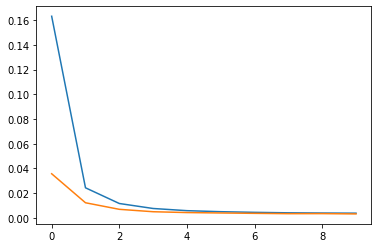

In [11]:
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss(weight = class_weights)
train_losses = []
val_losses = []
waited = 0

min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for embeddings_batch, labels_batch in batchify_tokens_tags(train_input, train_output, batch_size):
        optim.zero_grad()
        out = model.forward(embeddings_batch)
        
        # logits_final, labels_final = outputs_keep_useful_part(out.logits, labels_batch, useful_pos_batch)
        loss = criterion(out, labels_batch)
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(model, val_input, val_output, batch_size, criterion)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'saved_models/MOVE_AGENT_REQ_LSTM.pt')
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

plt.plot(train_losses)
plt.plot(val_losses)
plt.show()


In [12]:
model.load_state_dict(torch.load('saved_models/MOVE_AGENT_REQ_LSTM.pt'))

predicted_output = predict(model, test_input, batch_size)

acc = accuracy_score(test_output, predicted_output)
report = classification_report(test_output, predicted_output, target_names = mlb.classes_, digits = 3)
print(report)
print(f'acc = {acc}')

                       precision    recall  f1-score   support

      booking-bookday      0.000     0.000     0.000         5
   booking-bookpeople      0.000     0.000     0.000         3
     booking-bookstay      0.000     0.000     0.000         0
     booking-booktime      0.000     0.000     0.000         5
           hotel-area      0.000     0.000     0.000       164
        hotel-bookday      0.000     0.000     0.000        95
     hotel-bookpeople      0.000     0.000     0.000        54
       hotel-bookstay      0.000     0.000     0.000        92
       hotel-booktime      0.000     0.000     0.000         0
       hotel-internet      0.000     0.000     0.000        15
           hotel-name      0.000     0.000     0.000         4
        hotel-parking      0.000     0.000     0.000        19
     hotel-pricerange      0.000     0.000     0.000       110
          hotel-stars      0.000     0.000     0.000        35
           hotel-type      0.000     0.000     0.000  

/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/.local/lib/python3.10/site-packages/skle